#Creating the Bathymetry Grid

#Importing libraries

In [4]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, we obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For my model, I used a subset covering my grid ranging from -170*W to -160*W in longitude and 65*N to 75*N in latitude, and I stored the bathymetry data as `GEBCO_Bathymetry_California.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, we use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of the model.

In [5]:
# read in the bathymetry grid
file_path = 'C:\\Users\\Daniel\\Desktop\\185C_Project\\Data\\GEBCO_Bathymetry_Chukchi_Bering.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [6]:
# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/12
delY = 1/12
xgOrigin = -170
ygOrigin = 65
n_rows = 120
n_cols = 120

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (120,) (120,)


In [7]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [8]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, we create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

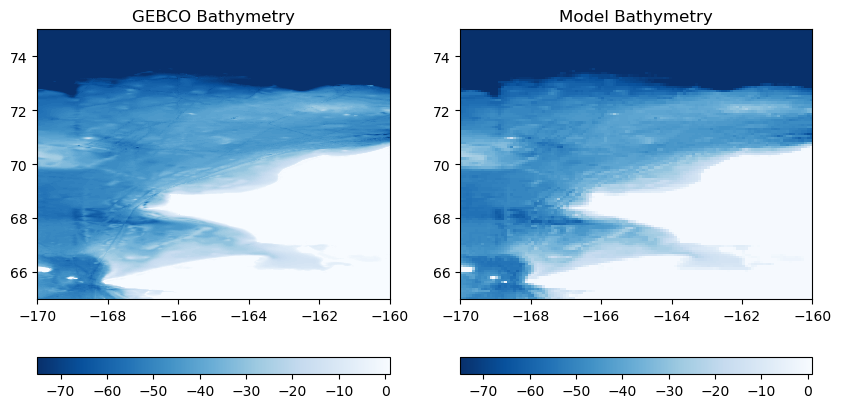

In [9]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-75, vmax=1, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-75, vmax=1, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

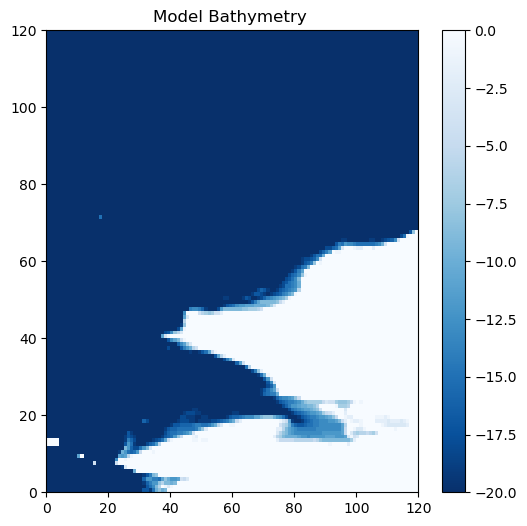

In [10]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-20, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

There is an isolated region of water to the easter of the bay.

Using Professor Wood's tool for filling unconnected regions:

In [11]:
from eccoseas.downscale import bathymetry as edb

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [12]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=100, central_wet_col=100)

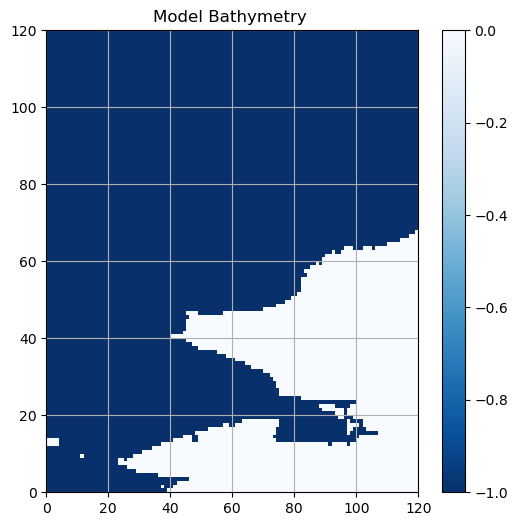

In [13]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')

plt.show()

### Checking for problem areas

In this example, I will fill in the Selawik Lake area, as it is a large inland lake generally unconnected to my experiment.

In [19]:
# Filling Lake Selawik
Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[66:66, -159:-160] = 0

Then, we plot the filled bathymetry to ensure it looks as expected

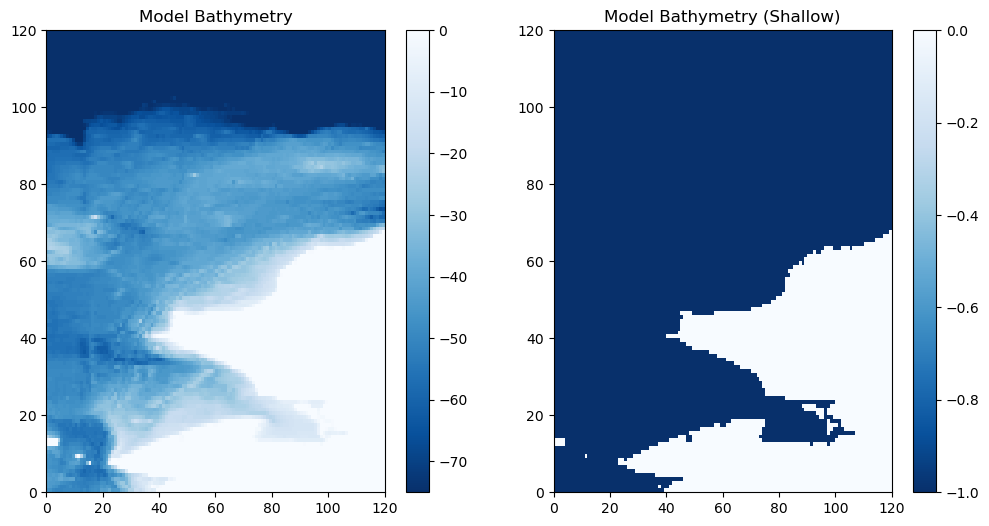

In [21]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-75, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')

plt.show()

In [22]:
output_file = 'CA_bathymetry.bin'
Model_bathy_filled.ravel('C').astype('>f4').tofile(output_file)